# Main goal: 
- Hani is looking for the final list of genes which are drug induced significantly methylated, expressed and stabilized. 

    ○ Venn diagram 

    ○ UpsetR 

=> table of these genes with all logFCs, pvalues and screening scores. 


In [1]:
# cp -v radar/result.all.txt hl60_delta_mtyl_table.txt

In [2]:
import pandas as pd 
import numpy as np
# Teated vs. non-treated 
comparisons = [
    # HL-60 meRIP-seq - logFC
    'meRIP-seq/hl60_delta_mtyl_table.txt' ,
    # HL-60 Ribo-seq - lnTE
    'Ribo-seq/hl60_delta_te_table.txt' ,
    # HL-60 RNA-seq 
    # RNA experssion - log2FC
    'RNA-seq/hl60-exp/hl60_delta_exp_table.txt',
    # RNA stability  - logFC
    'RNA-seq/hl60-stbl/hl60_delta_stbl_table.txt',
    ## 5 other AML cell lines RNA-seq
    # RNA experssion - log2FC
    'RNA-seq/other-exp/kg1_delta_exp_table.txt', 'RNA-seq/other-exp/molm14_delta_exp_table.txt',
    'RNA-seq/other-exp/ociaml2_delta_exp_table.txt', 'RNA-seq/other-exp/ociaml3_delta_exp_table.txt',
    'RNA-seq/other-exp/thp1_delta_exp_table.txt',
    # RNA stability - logFC
    'RNA-seq/other-stbl/kg1_delta_stbl_table.txt', 'RNA-seq/other-stbl/molm14_delta_stbl_table.txt',
    'RNA-seq/other-stbl/ociaml2_delta_stbl_table.txt', 'RNA-seq/other-stbl/ociaml3_delta_stbl_table.txt',
    'RNA-seq/other-stbl/thp1_delta_stbl_table.txt'
]


# extract cell line name experiment name 
names = [c.split('/')[-1].replace('.txt','').replace('_table','') for c in comparisons]
tables = [pd.read_csv(x, sep = '\t') for x in comparisons]
cells = [names[i].split('_')[0] for i,x in enumerate(comparisons)]
experiments = [names[i].replace(cells[i]+'_', '') for i,x in enumerate(comparisons)]

# read data into Pandas Data.Frames 
Data = dict(((c,{}) for c in cells))
for i,x in enumerate(comparisons): 
    cel = cells[i]
    exp = experiments[i]
    # read data and write into dictionary 
    Data [cel][exp] = tables[i]

Data['hl60']['delta_te'] = Data['hl60']['delta_te'][['gene_id','gene_name','Estimate_treatmentDRUG','fdr_Pr...z.._treatmentDRUG']]
Data['hl60']['delta_mtyl'] = Data['hl60']['delta_mtyl'][['ensembl','name','logFC','p_value']]
Data['hl60']['delta_mtyl'].columns = ['gene_id','gene_name','logFC','pval']

Let's include CRISPR screening scores 

In [3]:
def make_score_df(screen, score, rep='ave_Rep1_Rep2'):
    '''
    Make dataframe for given score from CRISPR screening Excel file 
    '''

    score_cols = [i for i,c in enumerate(screen.columns) if score in c]
    # extract screen informations from Excel file 
    screen_info = list(zip(
        score_cols,
        screen.iloc[0, score_cols].tolist(), 
        screen.iloc[1, score_cols].tolist(), 
        screen.columns[score_cols].tolist() 
    ))
    
    # select columns for given score
    cols = [c[0] for c in screen_info if c[1] == rep]
    # remove top 3 rows 
    df = screen.iloc[3:,cols]

    # set DataFrame column names from row 1
    df.columns = screen.iloc[1,cols].tolist()
    # add gene_name column
    gene_names = [str(g) for g in screen.iloc[3:,0]]
    df.insert (0, "gene_name", [g for g,t in zip(gene_names,df.transcripts)])
    # select rows with gene names  
    df = df.iloc[[i for i,g in enumerate(df.gene_name) if 'pseudo_' not in g],:].reset_index(drop=True)

    # only keep one transcript name
    df.transcripts = [str(g).split(',')[0] for g in df.transcripts]    
    # rename phenotype score column to the score name
    df.columns = [score + ' score' if x=='average phenotype of strongest 3' else x for x in df.columns]
    
    print (df.shape)
    return df

In [4]:
screen = pd.read_excel('screen/CRISPRi_HL60_DAC_genetable_collapsed.xlsx')

Data['hl60']['rho'] = make_score_df(screen, 'rho')
Data['hl60']['gamma'] = make_score_df(screen, 'gamma')

(18905, 6)
(18905, 6)


# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

In [5]:
Top = {}

In [6]:
def find_top(
    df,
    value, value_thr, stat, stat_thr,
    n_line=None, drop_dup=False):
    
    # Select rows (genes) which has value >= value_thr & stat < stat_thr 
    if n_line==None:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        
    # found in more than n_line cell lines 
    else:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line]
                ).all(axis=0)) if l == 1]
                ,:]
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line,]
                ).all(axis=0)) if l == 1]
                ,:] 
        
    if drop_dup==True:
        up = up.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
        dn = dn.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
    
    print ('up: ', up.shape)
    print ('down:', dn.shape)

    return up, dn


## Translational efficiency

In [7]:
Top['TE'] = {}

te_thr=0 # Estimate_treatmentDRUG
fdr_thr=0.2 # fdr_Pr...z.._treatmentDRUG

Top['TE']['threshold'] = [['te_thr',te_thr],['fdr_thr',fdr_thr]]

Top['TE']['up'], Top['TE']['down'] = find_top(
    Data['hl60']['delta_te'], 'Estimate_treatmentDRUG', te_thr, 'fdr_Pr...z.._treatmentDRUG', fdr_thr
)

up:  (157, 4)
down: (41, 4)


## $\Delta$RNA methylation

In [8]:
fc_thr = 2
pv_thr = 0.01

Top['Mtyl'] = {}

Top['Mtyl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Mtyl']['up'], Top['Mtyl']['down'] = find_top(
    Data['hl60']['delta_mtyl'], 
    'logFC', fc_thr, 'pval', pv_thr, drop_dup=True)

up:  (1417, 4)
down: (820, 4)


## $\Delta$RNA expression 

Extract experssion data for 6 AML cell lines:

In [9]:
E1 = Data['hl60']['delta_exp']
E2 = Data['kg1']['delta_exp']
E3 = Data['molm14']['delta_exp']
E4 = Data['ociaml2']['delta_exp']
E5 = Data['ociaml3']['delta_exp']
E6 = Data['thp1']['delta_exp']

load R

In [10]:
%reload_ext rpy2.ipython

In [11]:
%%R 
suppressMessages(suppressWarnings(library (tidyverse)))

Merge into one DataFrame:

In [12]:
%%R -i E1,E2,E3,E4,E5,E6 -o exp_df

exp_ids = E1[,'gene_id']
exp_names = E1[,'gene_name']

Exp = list(
    # hl60
    E1 %>% dplyr::select('gene_id','log2FC_120h','pval_120h') %>% 
            rename(hl60.log2FC=log2FC_120h,
                   hl60.pval=pval_120h), 
    # kg1
    E2 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(kg1.log2FC=log2FoldChange,
                   kg1.pval=pvalue),  
    # molm14
    E3 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(molm14.log2FC=log2FoldChange,
                   molm14.pval=pvalue), 
    # ociaml2
    E4 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(ociaml2.log2FC=log2FoldChange,
                   ociaml2.pval=pvalue), 
    # ociaml3    
    E5 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>% 
            rename(ociaml3.log2FC=log2FoldChange,
                   ociaml3.pval=pvalue), 
    # thp1
    E6 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(thp1.log2FC=log2FoldChange,
                   thp1.pval=pvalue) 
)

for (i in 1:6){
    Exp[[i]] = Exp[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('gene_id')
    Exp[[i]] = Exp[[i]][exp_ids,]
    
}

exp_df <- bind_cols(Exp) %>% add_column(gene_name=exp_names, .before=1)

In [13]:
exp_df.to_csv('delta_expression.txt')

In [14]:
Top['Exp'] = {}
fc_thr = 0.1
pv_thr = 0.1
Top['Exp']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Exp']['up'], Top['Exp']['down'] = find_top(
    exp_df, 
    [c for c in exp_df.columns if 'log2FC' in c], fc_thr,
    [c for c in exp_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (414, 13)
down: (142, 13)


## $\Delta$RNA stability

In [15]:
S1 = Data['hl60']['delta_stbl']
S2 = Data['kg1']['delta_stbl']
S3 = Data['molm14']['delta_stbl']
S4 = Data['ociaml2']['delta_stbl']
S5 = Data['ociaml3']['delta_stbl']
S6 = Data['thp1']['delta_stbl']

Merge stability results from all AML cell lines into one DataFrame:

In [16]:
%%R -i S1,S2,S3,S4,S5,S6 -o stbl_df

stbl_ids = S1[,'ensembl_id']
stbl_names = S1[,'gene_name']

Stbl = list(
    # hl60
    S1 %>% dplyr::select('ensembl_id','logFC_120h','P.Value_120h') %>% 
            rename(hl60.log2FC=logFC_120h,
                   hl60.pval=P.Value_120h), 
    # kg1
    S2 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(kg1.log2FC=logFC,
                   kg1.pval=P.Value),  
    # molm14
    S3 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(molm14.log2FC=logFC,
                   molm14.pval=P.Value), 
    # ociaml2
    S4 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(ociaml2.log2FC=logFC,
                   ociaml2.pval=P.Value), 
    # ociaml3    
    S5 %>% dplyr::select('ensembl_id','logFC','P.Value') %>% 
            rename(ociaml3.log2FC=logFC,
                   ociaml3.pval=P.Value), 
    # thp1
    S6 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(thp1.log2FC=logFC,
                   thp1.pval=P.Value) 
)

for (i in 1:6){
    Stbl[[i]] = Stbl[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('ensembl_id')
    Stbl[[i]] = Stbl[[i]][stbl_ids,]
    
}

stbl_df <- bind_cols(Stbl) %>% add_column(gene_name=stbl_names, .before=1)

In [17]:
exp_df.to_csv('delta_stability.txt')

In [18]:
Top['Stbl'] = {}

fc_thr = 0
pv_thr = 0.5

Top['Stbl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Stbl']['up'], Top['Stbl']['down'] = find_top(
    stbl_df, 
    [c for c in stbl_df.columns if 'log2FC' in c], fc_thr,
    [c for c in stbl_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (459, 13)
down: (502, 13)


## $\Delta$ Phenotype 

In [19]:
Top['Rho'] = {}

sc_thr = 0.05
pv_thr = 0.01

Top['Rho']['threshold'] = [['sc_thr',sc_thr],['pv_thr',pv_thr]]
Top['Rho']['up'], Top['Rho']['down']  = find_top(
    Data['hl60']['rho'], 
    'rho score', sc_thr,'Mann-Whitney p-value', pv_thr)

up:  (285, 6)
down: (274, 6)


# Plots

In [20]:
%reload_ext rpy2.ipython

In [21]:
%%R 
suppressMessages(suppressWarnings(library (UpSetR)))
suppressMessages(suppressWarnings(library (gplots)))
suppressMessages(suppressWarnings(library (patchwork)))

In [22]:
%%R 
intersect_plot <- function(Vecs){
    intersection <- Reduce(intersect,Vecs)
    SET = upset(fromList(Vecs), order.by = "freq")
    print (SET)
    
    VEN = venn (Vecs)
    
    return(intersection)
}

### Intersection of all genes across different datasets

In [23]:
M = list(set(Data['hl60']['delta_mtyl'].gene_name.tolist()))
T = list(set(Data['hl60']['delta_te'].gene_name.tolist()))
R = list(set(Data['hl60']['rho'].gene_name.tolist()))
S = list(set(stbl_df.gene_name.tolist()))
E = list(set(exp_df.gene_name.tolist()))

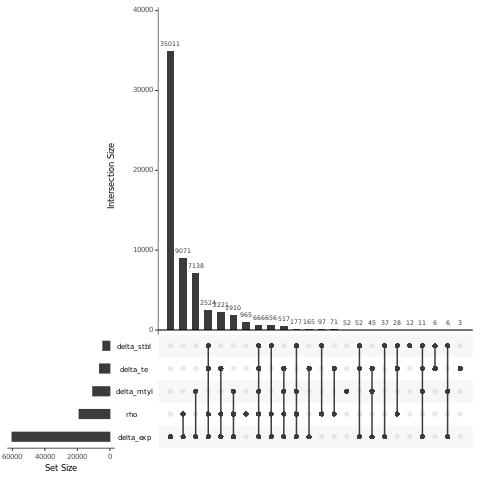

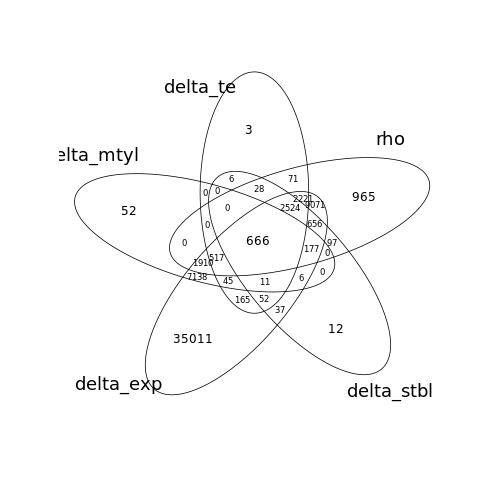

In [39]:
%%R -i M,T,R,S,E -o A

Vecs <- list(

    delta_mtyl = unlist(M),
    delta_te = unlist(T),
    rho = unlist(R),
    delta_stbl = unlist(S),
    delta_exp = unlist(E)
)

A = intersect_plot(Vecs)

### Up-regulated genes 

In [34]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Rho_up = Top['Rho']['up'].index.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

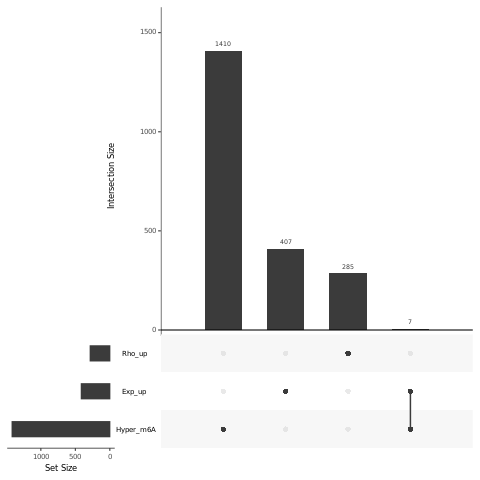

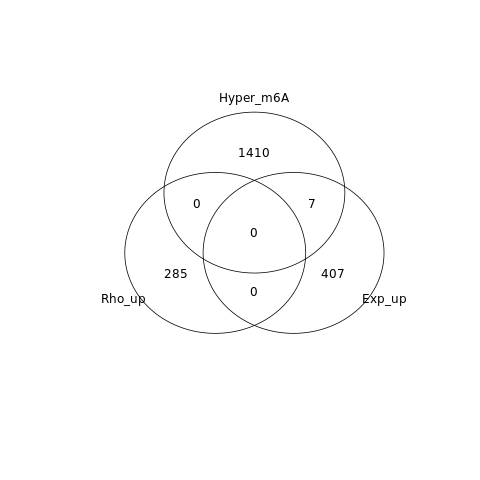

In [42]:
%%R -i Exp_up,Stbl_up,TE_up,Rho_up,Hyper_m6A
Vecs <- list(
    Rho_up=unlist(Rho_up), 
#     TE_up=unlist(TE_up), 
    Exp_up=unlist(Exp_up), 
#     Stbl_up=unlist(Stbl_up), 
    Hyper_m6A=unlist(Hyper_m6A)
)

up = intersect_plot(Vecs)

### Down regulated genes 

In [43]:
Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Rho_down = Top['Rho']['down'].index.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

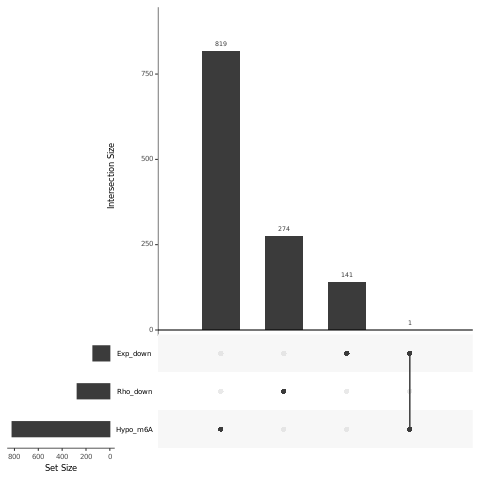

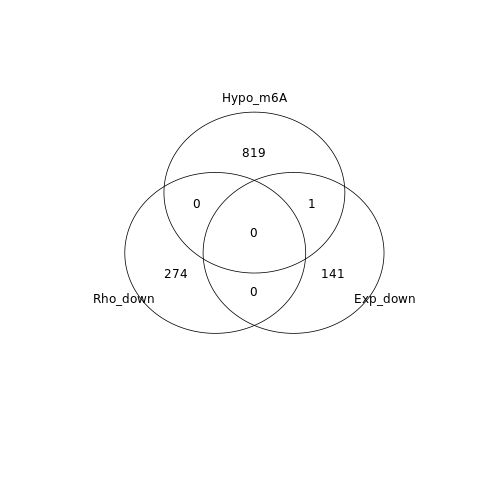

In [45]:
%%R -i Exp_down,Stbl_down,TE_down,Rho_down,Hypo_m6A
Vecs <- list(
    Rho_down=unlist(Rho_down), 
#     TE_down=unlist(TE_down), 
    Exp_down=unlist(Exp_down), 
#     Stbl_down=unlist(Stbl_down), 
    Hypo_m6A=unlist(Hypo_m6A)
)
dn = intersect_plot(Vecs)

# Final merged table

In [47]:
def get_intersect_df(df,k=None,A=A):
    if k is not None: 
        df = df[k]
    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(A)],]
    print (out.shape)
    return out

In [48]:
E = get_intersect_df(exp_df)
S = get_intersect_df(stbl_df)
M = get_intersect_df(Data['hl60'],'delta_mtyl')
T = get_intersect_df(Data['hl60'],'delta_te')
R = get_intersect_df(Data['hl60'],'rho')
G = get_intersect_df(Data['hl60'],'gamma')

(666, 13)
(666, 13)
(2830, 4)
(666, 4)
(666, 6)
(666, 6)


In [50]:
final = pd.DataFrame(index=A)

final = pd.concat([
    final,
    # Expression
    E.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Exp.'),
    # Stability 
    S.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Stbl.'),
    # Translational Efficiency 
    T.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('TE.'),
    # CRISPR Screen Rho score
    R.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Rho.'),
    # CRISPR Screen Gamma score
    G.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Gamma.')
    
],axis=1)
    
final.to_csv('combined.txt')

In [ ]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default


### Venn diagram 

- https://python-graph-gallery.com/172-custom-venn-diagram/
- https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
- https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305


- https://anaconda.org/conda-forge/r-venn
- https://pypi.org/project/venn/

In [29]:
# # Import the library
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import combinations
# from matplotlib_venn import venn3

# def venn_diagram(a, b, c, labels=['A', 'B', 'C']):
    
#     a = list(set(a))
#     b = list(set(b))
#     c = list(set(c))
    
#     only_a = len( [x for x in a if x not in b+c] )
#     only_b = len( [x for x in b if x not in a+c] )
#     only_c = len( [x for x in c if x not in a+b] )

#     a_b = len(np.intersect1d(a, b))
#     a_c = len(np.intersect1d(a, c))
#     b_c = len(np.intersect1d(b, c))
    
#     a_b_c = len([ x for x in a if (x in b) and (x in c)])
    
#     venn3(subsets=(only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)    
    
# def iter_venn(datasets, names):
#     # unique permutations on the number of given datasets 
#     iterations = list(combinations(list(range(len(datasets))), 3))
#     # draw unique venn_diagrams
#     for i,iteration in enumerate(iterations):
#         p = plt.figure(i)
#         a,b,c=[datasets[n] for n in iteration]
#         venn_diagram(a,b,c,labels=[names[n] for n in iteration]
#         )
#         p.show()    